# 2 - OPES metad
We use [OPES_METAD](https://www.plumed.org/doc-v2.8/user-doc/html/_o_p_e_s__m_e_t_a_d.html) and [OPES_METAD_EXPLORE](https://www.plumed.org/doc-v2.8/user-doc/html/_o_p_e_s__m_e_t_a_d__e_x_p_l_o_r_e.html) to enhance sampling of collective variables.
</br>
The systems used are alanine dipeptide in vacuum (ala2), and alanine tetrapeptide in vacuum (ala4).

In [1]:
root_path = '../' #change this if you move the nootebook somewhere else

import numpy as np
import plumed

import sys
sys.path.append(root_path + 'scripts') #dirty way to import our script
from calcFES import calcFES, calcDeltaF, calcESS

In [2]:
#reuse same plumed kernel, to avoid multiple warnings
PLUMED_KERNEL=plumed.Plumed()
from functools import partial
plumed.read_as_pandas = partial(plumed.read_as_pandas, kernel=PLUMED_KERNEL)

+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/home/mi/minvernizzi/miniconda3/envs/plumed-masterclass-2022/lib/libplumedKernel.so" +++


In [3]:
#plot-related stuff
import matplotlib.pyplot as plt
from IPython.display import clear_output

#set bigger font sizes
SMALL_SIZE = 11
MEDIUM_SIZE = 12
BIG_SIZE = 15
plt.rc('font', size=SMALL_SIZE)        # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)   # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)  # legend fontsize
plt.rc('figure', titlesize=BIG_SIZE)   # fontsize of the figure title

try:
# https://github.com/luigibonati/fessa-color-palette/blob/master/fessa.py
    import fessa
    plt.set_cmap('fessa')
except:
    pass # no big deal

<Figure size 432x288 with 0 Axes>

In [4]:
#useful constants for our simulations
KB = 0.0083144621
T0 = 300
BETA0 = 1/(KB*T0)
KBT = KB*T0

DF = 9.04
FES1D = plumed.read_as_pandas(root_path+'inputs-ala2/ref-fes1D.dat')
FES2D = plumed.read_as_pandas(root_path+'inputs-ala2/ref-fes2D.dat')

In [5]:
#shorthand for the used methods
methods = ['opes', 'explore', 'metad']
labels = {'opes' : 'OPES_METAD', 'explore' : 'OPES_METAD_EXPLORE', 'metad' : 'METAD'}
colors = {'opes' : "#E69138", 'explore' : "#674EA7", 'metad' : "#6AA84F"}

## 2.1 - Biasing a good CV: $\phi$

In [6]:
folder_ = root_path + '2-opes_metad/phi-%s/'

colvars = {}
for method in methods[::2]: #skip explore for now
    colvars[method] = plumed.read_as_pandas(folder_%method+'COLVAR')

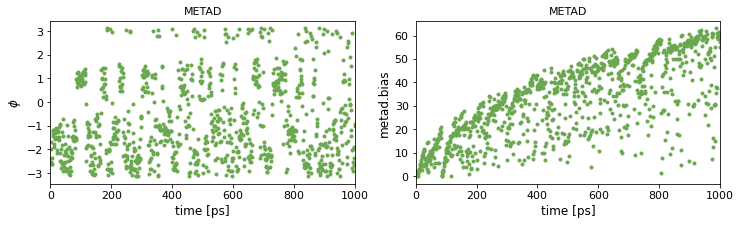

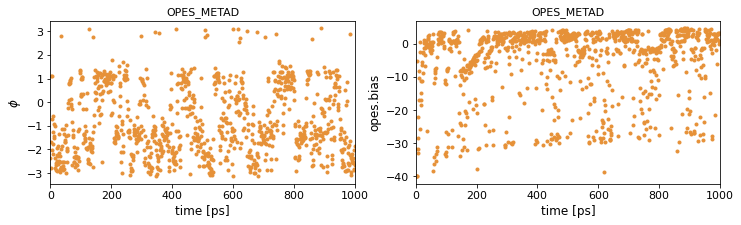

In [7]:
def plot_colvar(ax, method, cv, fmt='.', colvars=colvars):
    colvar = colvars[method]
    ax.plot(colvar['time'], colvar[cv], fmt, color=colors[method], label=cv)
    ax.set_xlim(colvar['time'].min(), colvar['time'].max())
    ax.set_xlabel('time [ps]')
    if cv == 'phi':
        ax.set_ylabel('$\phi$')
    elif cv == 'psi':
        ax.set_ylabel('$\psi$')
    else:
        ax.set_ylabel(cv)
    ax.set_title(labels[method])

def plot_two_cvs(method, cv1, cv2, fmt='.', colvars=colvars):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches((12, 3))
    plot_colvar(ax1, method, cv1, fmt, colvars=colvars)
    plot_colvar(ax2, method, cv2, fmt, colvars=colvars)
    plt.show()

plot_two_cvs('metad', 'phi', 'metad.bias')
plot_two_cvs('opes', 'phi', 'opes.bias')

Now let's check the other output components of the OPES_METAD run.

The `rct` quantity is defined as the one in METAD, and calculated as an ensemble average:
$$c(t)=\frac{1}{\beta}\log \left[\frac{1}{n}\sum_k^n e^{\beta V_k(s_k)}\right]$$
Contrary to METAD, it converges to a constant as the bias becomes quasi-static.
Thus, it can be a quick indication of how things are going.

The `zed` term starts from 1 and changes significantly only when a new region of CV space is sampled. It also can be a handy indicator, especially when biasing multiple CVs. The details of how its calculated are in the supporting information of Ref [66](https://pubs.acs.org/doi/10.1021/acs.jpclett.0c00497).

Here is how these two terms look like:

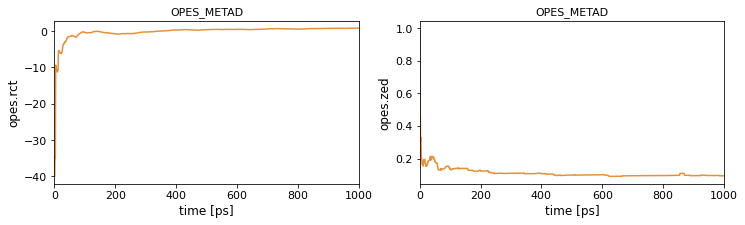

In [8]:
#some extra information about the OPES run
plot_two_cvs('opes', 'opes.rct', 'opes.zed', '-')

The effective sample size `neff` can also be stored. In a good run it should always increase, with a fixed ratio to the number of samples, that depends on the chosen target distribution.
`neff` is used to determine the shrinking of the bandwidth, according to Eq.6 of Ref.[66](https://pubs.acs.org/doi/10.1021/acs.jpclett.0c00497). 

The number of compressed kernels used to represent the probability estimate is stored in `nker`. This should be significantly smaller than the total number of deposited kernels, which is equal to the number of iterative steps $n$ ($n=1000$ in this example). As long as the bandwidth slowly shrinks it should slowly increase. This leads to a more accurate probability estimate, especially if the FES has small features.
If this is not the case, or if you plan a very long simulation, it is possible to set a `SIGMA_MIN`, and the bandwidth will not decrease further. Also, if a simulation already looks good one can use the `FIXED_SIGMA` keyword when restarting, and keep the bandwidth constant to limit the growth of `nker`.

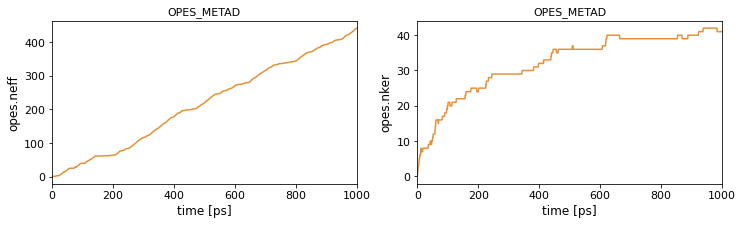

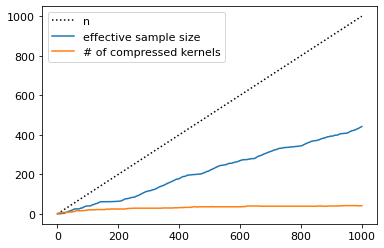

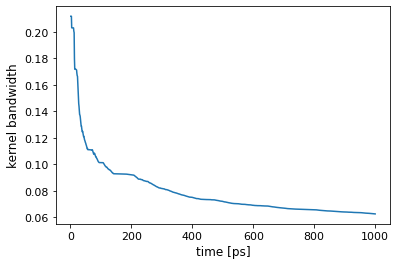

In [9]:
#some extra information about the OPES run
plot_two_cvs('opes', 'opes.neff', 'opes.nker', '-')

plt.plot(colvars['opes']['time'], colvars['opes']['time'], ':k', label='n')
plt.plot(colvars['opes']['time'], colvars['opes']['opes.neff'], label='effective sample size')
plt.plot(colvars['opes']['time'], colvars['opes']['opes.nker'], label='# of compressed kernels')
plt.legend()
plt.show()

kernels = plumed.read_as_pandas(folder_%'opes'+'KERNELS')
plt.plot(kernels['time'], kernels['sigma_phi'])
plt.xlabel('time [ps]')
plt.ylabel('kernel bandwidth')
plt.show()

Now let's look at some free energy estimates.

As usual in metadynamics, the bias potential at time t, $V_t(\phi)$, can be used to estimate the FES:
$$F_t(\phi)=-(1-1/\gamma)V_t(\phi)$$
Its time evolution gives us an idea of the different behaviour of the two methods. In OPES the bias adapts quickly, and then only small adjustments are made. It also does not grow much above the chosen BARRIER.

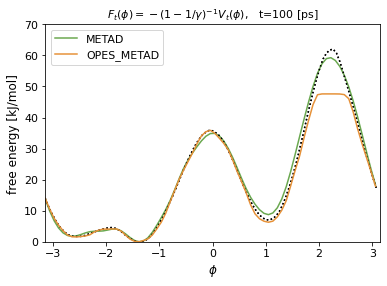

In [10]:
#Let's see how the bias evolves in time
try:
    grid_opes = plumed.read_as_pandas(folder_%'opes'+'fes_running/fes_100.dat', usecols=[0]).to_numpy()
except:
    myfolder = folder_%'opes'
    !mkdir {myfolder}fes_running
    !{root_path}scripts/FES_from_State.py --state {myfolder}STATE --temp {T0} --all_stored --bin 75 -o {myfolder}fes_running/
    grid_opes = plumed.read_as_pandas(folder_%'opes'+'fes_running/fes_100.dat', usecols=[0]).to_numpy()
try:
    grid_metad = plumed.read_as_pandas(folder_%'metad'+'fes_running/fes_100.dat', usecols=[0]).to_numpy()
except:
    myfolder = folder_%'metad'
    !mkdir {myfolder}fes_running
    !plumed sum_hills --hills {myfolder}HILLS --mintozero --bin 75 --outfile {myfolder}fes_running/fes_ --stride 10
    for i in reversed(range(100)): #fes_99.dat and fes_100.dat are equal
        !mv {myfolder}fes_running/fes_{i}.dat {myfolder}fes_running/fes_{i+1}.dat
    grid_metad = plumed.read_as_pandas(folder_%'metad'+'fes_running/fes_100.dat', usecols=[0]).to_numpy()

#now the plotting
def plot_fes1D(grid, fes, max_fes=70, ref_fes=True, **kwargs):
    if ref_fes:
        plt.plot(FES1D.iloc[:,0], FES1D.iloc[:,1],':k')
    plt.plot(grid, fes, **kwargs)
    plt.xlim(-np.pi, np.pi)
    plt.ylim(0, max_fes)
    plt.xlabel('$\phi$')
    plt.ylabel('free energy [kJ/mol]')

for i in range(100):
    clear_output(wait=True)
    fes_metad = plumed.read_as_pandas(folder_%'metad'+f'fes_running/fes_{i+1}.dat', usecols=[1]).to_numpy()
    fes_opes = plumed.read_as_pandas(folder_%'opes'+f'fes_running/fes_{i+1}.dat', usecols=[1]).to_numpy()
    plt.title(f'$F_t(\phi)=-(1-1/\gamma)^{{-1}}V_t(\phi)$,   t={i+1} [ps]')
    plot_fes1D(grid_metad, fes_metad, color=colors['metad'], label=labels['metad'])
    plot_fes1D(grid_opes, fes_opes, color=colors['opes'], label=labels['opes'])
    plt.legend(loc='upper left')
    plt.show()

We can also obtain the FES via reweighting. This is the suggested method for OPES, while for METAD several different reweighting schemes have been proposed, we consider two of the most popular.

We assume that after an initial transient the bias is quasi-static. In this case, where a good CV is used, this is a good assumption for both OPES and METAD.

We use a weighted kernel density estimation, similar to the one available in the PLUMED driver.

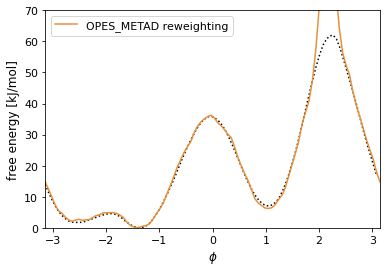

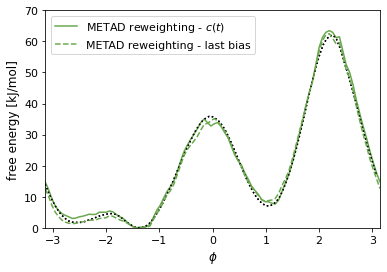

In [11]:
#reweighting is the suggested way to estimate the FES in OPES.
transient = 200
bandwidth = 0.05
grid_phi = np.linspace(-np.pi, np.pi, 100)

#opes
phi = colvars['opes']['phi'][transient:]
logweights = colvars['opes']['opes.bias'][transient:]/KBT
fes_opes = KBT*calcFES(grid_phi, bandwidth, phi, logweights, periodic=True)

plot_fes1D(grid_phi, fes_opes, label='OPES_METAD reweighting', color=colors['opes'])
plt.legend()
plt.show()

#metad has various ways for reweighting...
phi = colvars['metad']['phi'][transient:]
#rct reweighting:
logweights = colvars['metad']['metad.rbias'][transient:]/KBT
fes_metad_rct = KBT*calcFES(grid_phi, bandwidth, phi, logweights, periodic=True)
#last bias reweighting:
gamma = float(plumed.read_as_pandas(folder_%'metad'+'HILLS', usecols=['biasf']).iloc[0])
fes_metad_df = plumed.read_as_pandas(folder_%'metad'+f'fes_running/fes_{100}.dat', usecols=[0,1])
last_bias = -(1-1/gamma)*fes_metad_df.iloc[:,1]
logweights = np.interp(phi, fes_metad_df.iloc[:,0], last_bias)/KBT
fes_metad_rlb = KBT*calcFES(grid_phi, bandwidth, phi, logweights, periodic=True)

plot_fes1D(grid_phi, fes_metad_rct, color=colors['metad'], label='METAD reweighting - $c(t)$ ')
plot_fes1D(grid_phi, fes_metad_rlb, color=colors['metad'], ls='--', label='METAD reweighting - last bias')
plt.legend()
plt.show()

So, in this simple example, with a good 1-dimensional CV, both methods work great and all the FES estimates are pretty accurate even with such a short simulation.
We can run this also with OPES_METAD_EXPLORE, and we will find similar results.

The simulations we run were sampling a well-tempered distribution with a bias factor $\gamma \approx 16$. We can also sample a target distribution with a uniform probability along $\phi$. To do this in OPES one just has to set `BIASFACTOR=inf`. How does the effective sampling size change?

## 2.2 - Biasing two good CVs: $\phi$ and $\psi$
We now show how OPES handles higher dimensional biases. We still use good CVs.

In [12]:
folder_ = root_path + '2-opes_metad/phi_psi-%s/'

First we run alanine dipeptide $\phi$ and $\psi$ angles.
This time we will let OPES choose the proper `SIGMA`. It will measure the fluctuations of the CVs to do that.
So, the only input will be: `PACE=500 BARRIER=40`.

We want to visualize the kernel compression algorithm in this 2D case, so we will also dump the STATE of the simulation. We add a new kernel each ps of the simulation, but if it is close enough to another kernel already present, we will instead merge them, with a simple rule that can be found in the supporting information of Ref. [66](https://pubs.acs.org/doi/10.1021/acs.jpclett.0c00497).

In [13]:
#some plotting functions
max_fes = 50 #kJ/mol

from matplotlib.patches import Ellipse
import matplotlib.colors as colors
from matplotlib.collections import PatchCollection

def plot_ala2_kernels(ax, kernels, scale=1, max_fes=max_fes, period=2*np.pi):
    def add_kernels(dx=0, dy=0):
        pc = PatchCollection([ Ellipse(xy=(ker[1]-dx,ker[2]-dy), width=ker[3], height=ker[4]) for ker in kernels ])
        pc.set_array(np.minimum(max_fes, -KBT*scale*np.log(kernels[:,5]/max(kernels[:,5]))))
        pc.set_clim((0, max_fes))
        ax.add_collection(pc)
        return pc
    pc = add_kernels()
    if period is not None:
        add_kernels( period, 0)
        add_kernels(-period, 0)
        add_kernels(0,  period)
        add_kernels(0, -period)
    ax.set_aspect('equal')
    ax.set_xlim(-np.pi, np.pi)
    ax.set_ylim(-np.pi, np.pi)
    ax.set_xlabel('$\phi$')
    ax.set_ylabel('$\psi$')
    ax.grid(ls='--')
    return pc

def plot_ala2_fes(ax, fes, max_fes=None):
    if max_fes is None:
        max_fes = np.amax(fes)
    im = ax.imshow(fes, vmax=max_fes, origin='lower', extent=(-np.pi,np.pi,-np.pi,np.pi))
    cb = fig.colorbar(im, ax=ax, label='free energy [kJ/mol]')
    ax.set_yticks([-2,0,2])
    ax.set_aspect('equal')
    ax.set_xlabel('$\phi$')
    ax.set_ylabel('$\psi$')
    return cb

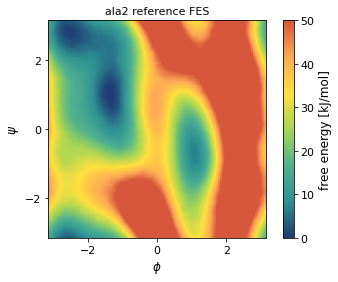

In [14]:
#as reference here is a converged ala2 FES
fig, ax = plt.subplots()
nbins = int(np.sqrt(len(FES2D.iloc[:,2])))
plot_ala2_fes(ax, FES2D.iloc[:,2].to_numpy().reshape(nbins,nbins), max_fes)
ax.set_title('ala2 reference FES')
plt.show()

In [15]:
#load both STATE files and the FES estimates
def load_states(filename):
    #check if OPES_METAD, or OPES_METAD_EXPLORE and set kernels scaling
    f = open(filename, 'r')
    line = f.readline() #fields
    line = f.readline() #action
    if line.split()[3] == 'OPES_METAD_state':
        scale = 1
    elif line.split()[3] == 'OPES_METAD_EXPLORE_state':
        line = f.readline()
        scale = float(line.split()[3]) #biasfactor
    else:
        assert False, filename+' is not an OPES STATE file'
    f.close()
    #read state file
    all_kernels = plumed.read_as_pandas(filename).to_numpy()
    times = np.unique(all_kernels[:,0])
    return all_kernels, scale, times

kernels_opes, _, times = load_states(folder_%'opes'+'STATE')
kernels_expl, gamma, _ = load_states(folder_%'explore'+'STATE')

def load_fes(method, tot, fes_folder=folder_+'fes_running/', state_filename=folder_+'STATE'):
    try:
        filename = fes_folder%method+f'fes_1.dat'
        X = plumed.read_as_pandas(filename, usecols=[0]).to_numpy()
    except:
        !mkdir {fes_folder%method}
        !{root_path}scripts/FES_from_State.py --temp {T0} --all_stored -f {state_filename%method} -o {fes_folder%method}
        filename = fes_folder%method+f'fes_1.dat'
        X = plumed.read_as_pandas(filename, usecols=[0]).to_numpy()
    fes = []
    for i in range(tot):
        filename = fes_folder%method+f'fes_{1+i}.dat'
        fes_i = plumed.read_as_pandas(filename, usecols=[2]).to_numpy()
        nbins = int(np.sqrt(len(fes_i)))
        fes.append(fes_i.reshape(nbins, nbins))
        print(f'loading FES files... {(i+1)/tot:.0%}  ', end='\r')
    return X.reshape(nbins,nbins), fes
        
X, fes_opes = load_fes('opes', len(times))
_, fes_expl = load_fes('explore', len(times))

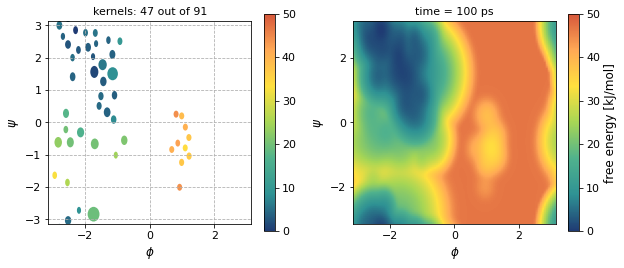

In [16]:
for i,t in enumerate(times):
    clear_output(wait=True)
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches((10, 4))
    
    ker_t = kernels_opes[kernels_opes[:,0]==t]
    ax1.set_title(f'kernels: {len(ker_t)} out of {t-9:g}')
    pc = plot_ala2_kernels(ax1, ker_t, scale=1, max_fes=max_fes)
    fig.colorbar(pc, ax=ax1)
    
    ax2.set_title(f'time = {t:g} ps')
    plot_ala2_fes(ax2, fes_opes[i], max_fes=max_fes)
    plt.show()

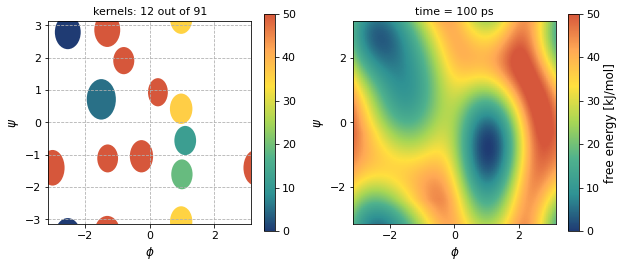

In [17]:
for i,t in enumerate(times):
    clear_output(wait=True)
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches((10, 4))
    
    ker_t = kernels_expl[kernels_expl[:,0]==t]
    ax1.set_title(f'kernels: {len(ker_t)} out of {t-9:g}')
    pc = plot_ala2_kernels(ax1, ker_t, scale=gamma, max_fes=max_fes)
    fig.colorbar(pc, ax=ax1)
    
    ax2.set_title(f'time = {t:g} ps')
    plot_ala2_fes(ax2, fes_expl[i], max_fes=max_fes)
    plt.show()

We can see that OPES_METAD_EXPLORE uses fewer kernels than OPES_METAD and is faster in exploring the FES, but it also has a less stable bias. Let's see how is the corresponding $\Delta F$ estimate.

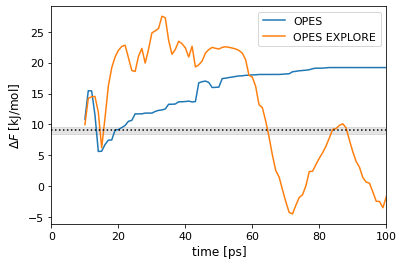

In [18]:
deltaF_opes = np.array([calcDeltaF(fes, X<0, kbt=KBT) for fes in fes_opes])
deltaF_expl = np.array([calcDeltaF(fes, X<0, kbt=KBT) for fes in fes_expl])
# deltaF_metad = np.array([calcDeltaF(fes, X<0) for fes in fes_metad])

plt.plot(times, deltaF_opes, label='OPES')
plt.plot(times, deltaF_expl, label='OPES EXPLORE')
# plt.plot(times, deltaF_metad, label='METAD')
plt.axhline(DF, ls=':', color='black')
plt.axhspan(DF-.5, DF+.5, alpha=.1, color='black')
plt.xlim(0, times[-1])
plt.xlabel('time [ps]')
plt.ylabel('$\Delta F$ [kJ/mol]')
plt.legend()
plt.show()

We can run the same simulation with metadynamics, and see how it goes.

But 100 ps is a really short time, we should run a longer simulation and see how the estimates evolve, and how $\Delta F$ improves.
Remember to increase accordingly the `STATE_WSTRIDE`, to reduce the number of stored estimates, so for instance for a simulation of 1000 ps we can use `STATE_WSTRIDE=500*10`.
Using a neighbor list will speed up things when there are many kernels, so we should add the `NLIST` keyword.
We can also restart a previous simulation.

It would be interesting also to see how the reweighting estimate behaves.
To do that we don't need the STATE file, but just the COLVAR. The `FES_from_Reweighting.py` script can be used, in a very similar way to `plumed sum_hills`.

## 2.3 - Biasing more CVs: alanine tetrapeptide
Now we use alanine tetrapeptide (ala4) that has 3 $\phi$ angles. We just look at how quickly we can find all the 8 metastable states, using the `get_ala4_basin.sh` script.
This script generates a file which contains for each time the current state and the total amount of visited states.

With three CVs the zed term of OPES_METAD plays a really important role, we can try to remove it an see the difference. 

Also, now changing the bias factor $\gamma$ will have a big impact over the sampling efficiency.

In [19]:
folder_ = root_path + '2-opes_metad/ala4-%s/'

## 2.4 - Biasing a suboptimal CV

Finally we will bias again ala2, but using a suboptimal CV. You can find the CV definition in the input file, you will have to choose the proper parameters and run METAD, OPES_METAD_EXPLORE and OPES_METAD.

We will discuss together the results.

Why is this a suboptimal CV? What happens if we bias it together with $\psi$?

In [20]:
folder_ = root_path + '2-opes_metad/subCV-%s/'

**Bonus exercise:**</br>
Rerun a metadynamics simulation that you had run in the past, but using instead OPES_METAD_EXPLORE and/or OPES_METAD